In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime
import random
import os

import warnings
warnings.filterwarnings(action='ignore') 

In [31]:
# ID 제외 데이터 갖고오기 

train = pd.read_csv('../../DATA/train.csv')
test  = pd.read_csv('../../DATA/test.csv').drop(columns=['ID'])
trade = pd.read_csv('../../DATA/international_trade.csv')
dlinear = pd.read_csv('../../DATA/SUBMIT/Dlinear1.csv').rename(columns={'answer': 'price'})#711 
nlinear =pd.read_csv('../../DATA/SUBMIT/Nlinear2.csv').rename(columns={'answer': 'price'} )#698
lstm = pd.read_csv('../../DATA/SUBMIT/lstm1.csv').rename(columns={'answer': 'price'} )#795
lstf = pd.read_csv('../../DATA/SUBMIT/lstf1.csv').rename(columns={'answer': 'price'} )#710
sundayzero_automl_sub = pd.read_csv('../../DATA/SUBMIT/sundayzero_automl_sub.csv').rename(columns={'answer': 'price'} )#747
xgb_opt = pd.read_csv('../../DATA/SUBMIT/new_ens_opt_xgb_tarenc_sub2.csv').rename(columns={'answer': 'price'} )#1135
new_automl = pd.read_csv('../../DATA/SUBMIT/new_automl_sub.csv').rename(columns={'answer': 'price'} )#979.8714617979
new_automl_nlinear = pd.read_csv('../../DATA/SUBMIT/newautoml_nlinear.csv')
nlinear_interpol = pd.read_csv('../../DATA/SUBMIT/Nlinear_interpolate.csv').rename(columns={'answer': 'price'} )
nlinear_customlosst = pd.read_csv('../../DATA/SUBMIT/Nlinear_customloss.csv').rename(columns={'answer': 'price'} )
patchTST = pd.read_csv('../../DATA/SUBMIT/patchTST_minfixed.csv').rename(columns={'answer': 'price'} )

In [32]:
# 데이터 타입 변경, 열 이름 변경 

new_column_names = {
    'corporation': 'corp',
    'location': 'loc',
    'supply(kg)': 'supply',
    'price(원/kg)': 'price',
}

train = train.rename(columns=new_column_names)
test = test.rename(columns=new_column_names)

train['timestamp']  = pd.to_datetime(train['timestamp'])
test['timestamp']  = pd.to_datetime(test['timestamp'])



In [33]:
def make_check_data(method ) :
    checking_data = pd.DataFrame() 
    for i in range(39):
        start = i*1523
        end = start + 1523
        # i*1523 ~ (i+1)*1523 의 행들 선택
        temp_df_a = train.iloc[start:end, [0, -1]]
        # b 데이터에서 필요한 부분 선택
        temp_df_b = method.iloc[i*28:(i+1)*28]
        # 선택된 a 데이터, b 데이터를 합침
        temp_df = pd.concat([temp_df_a, temp_df_b])
        # 최종 데이터프레임에 추가
        checking_data = pd.concat([checking_data, temp_df])
    checking_data.reset_index(drop= True , inplace=True) 
    checking_data['item'] = checking_data['ID'].astype(str).str[0:6]
    checking_data['timestamp'] = checking_data['ID'].astype(str).str[-8:]
    checking_data['timestamp'] = pd.to_datetime(checking_data['timestamp'], format='%Y%m%d')
    return checking_data 


def make_graph_for_each(data): 
    for i in range(39) :
        start = i*1551
        end = (i+1)*1551
        
        temp_df = data.iloc[start:end]
        temp_df = temp_df.set_index('timestamp')
        temp_df.index = pd.to_datetime(temp_df.index)
        item = temp_df.iloc[0 , 2]
        plt.figure(figsize=(8,5))
        march_data = temp_df[(temp_df.index.month == 3) & (temp_df.index.day >= 4) & (temp_df.index.day <= 31)]
        plt.plot(march_data['price'], color='red')
        
        # 나머지 데이터를 파란색으로 표시
        other_data = temp_df[~((temp_df.index.month == 3) & (temp_df.index.day >= 4) & (temp_df.index.day <= 31))]
        plt.plot(other_data['price'], color='blue')
        
        plt.title(f'Price Plot for  {item}')
        plt.xlabel('Index')
        plt.ylabel('Price')
        plt.show()


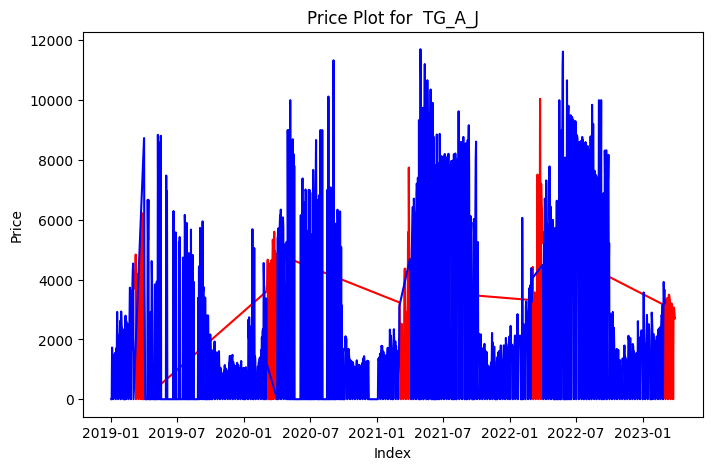

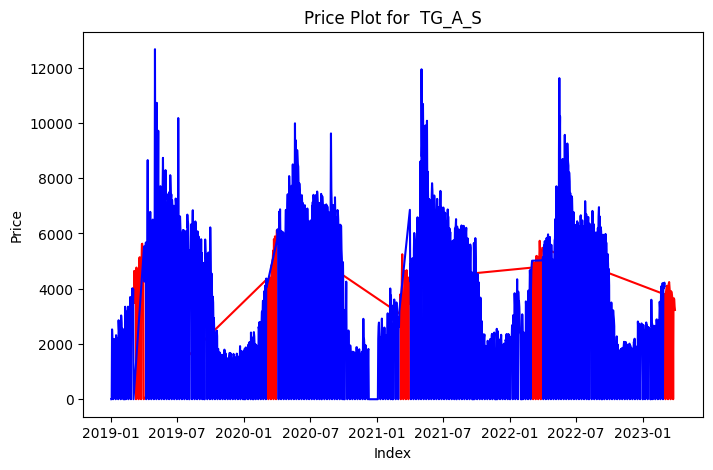

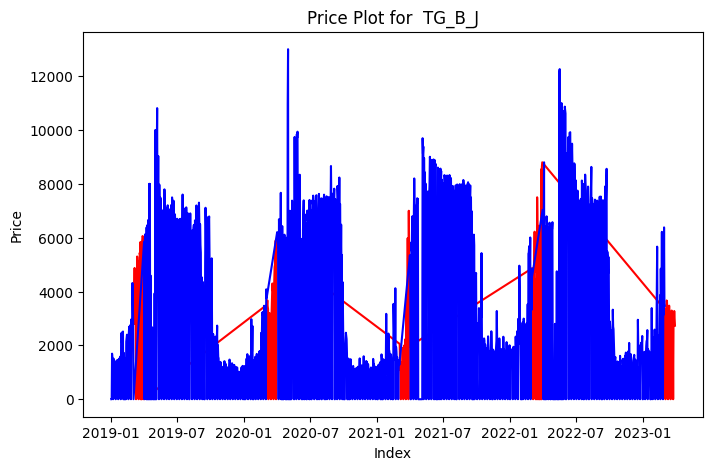

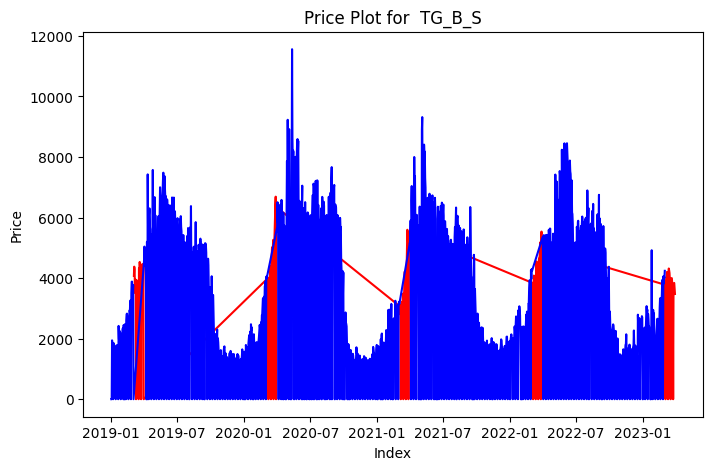

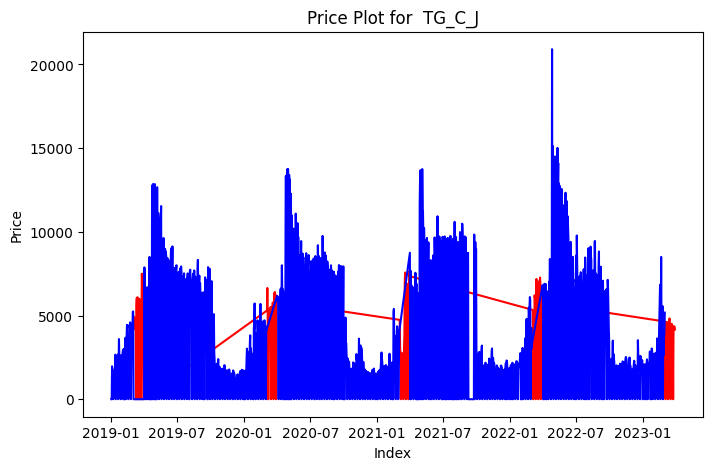

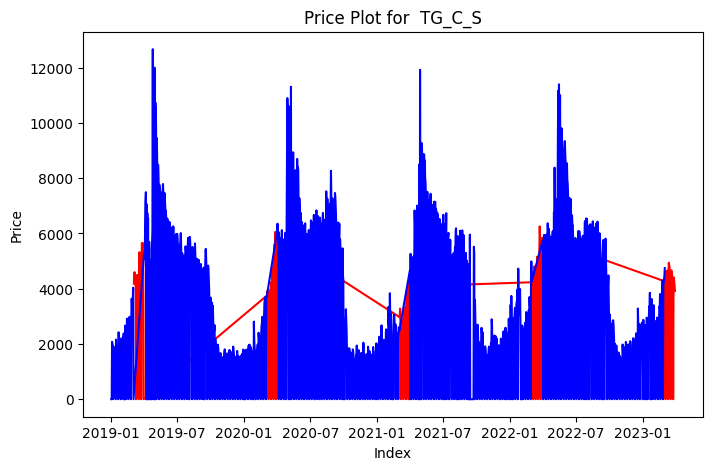

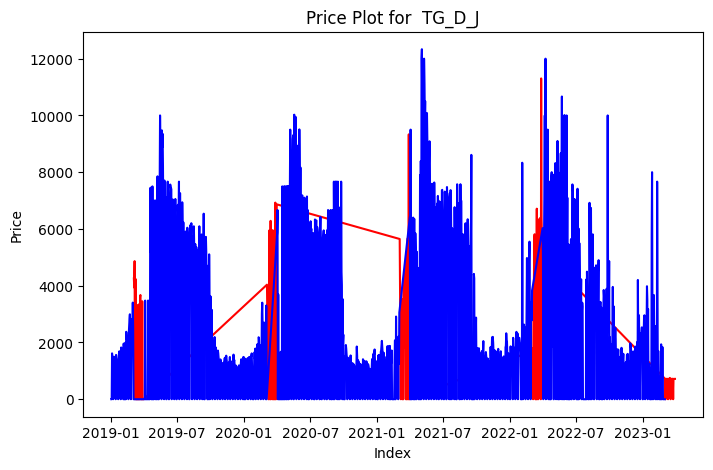

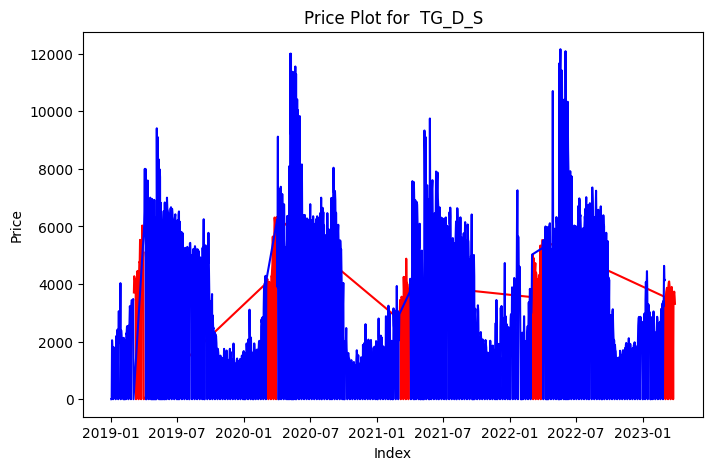

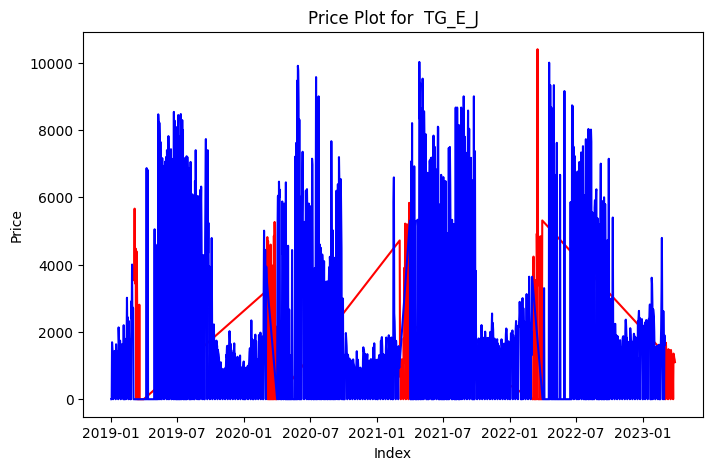

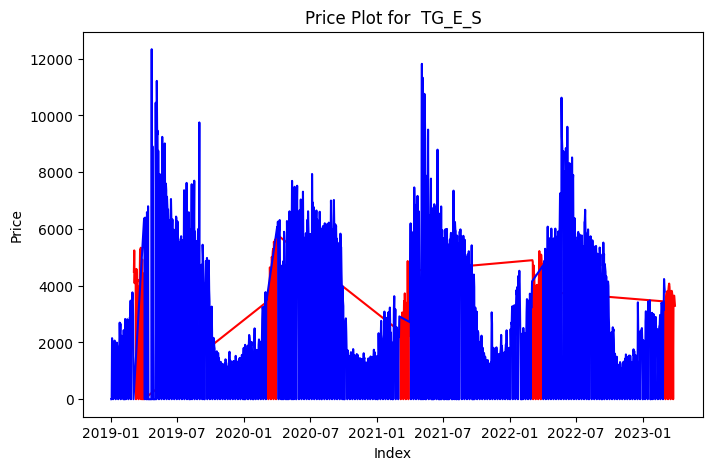

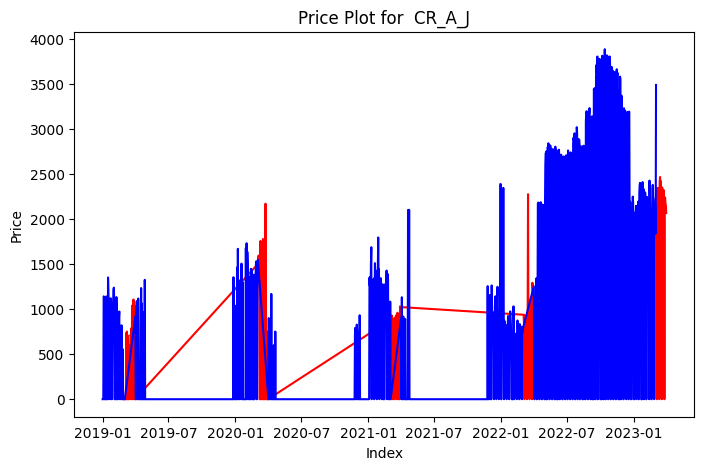

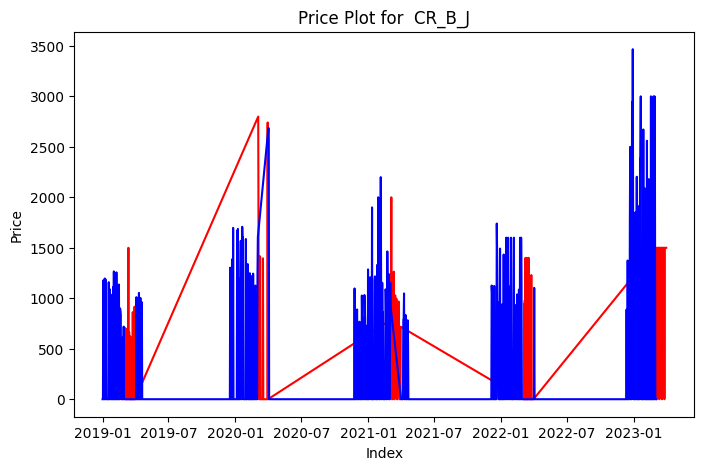

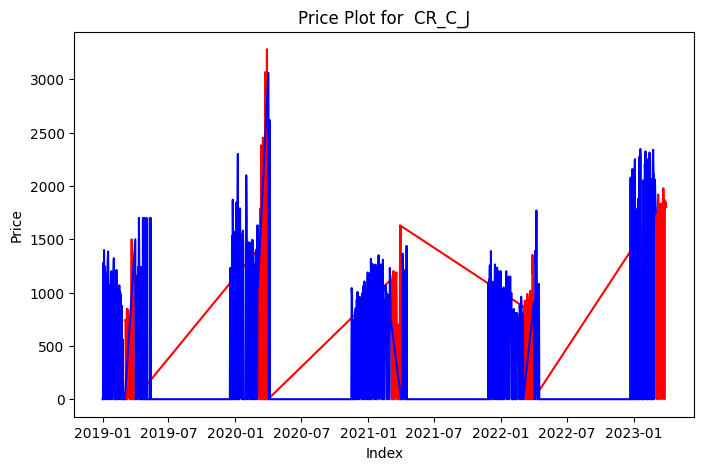

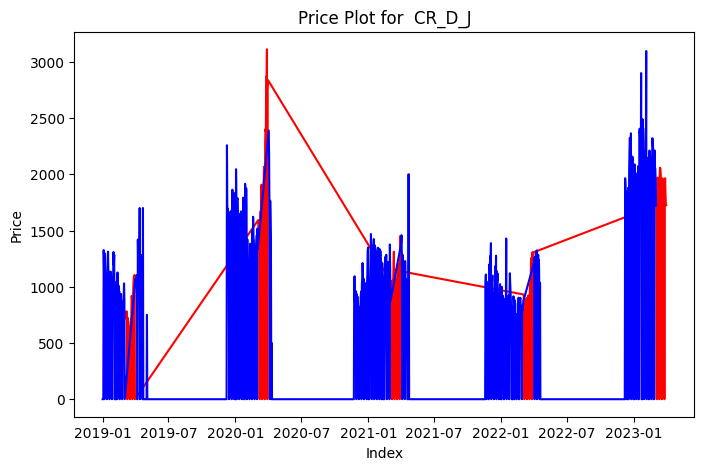

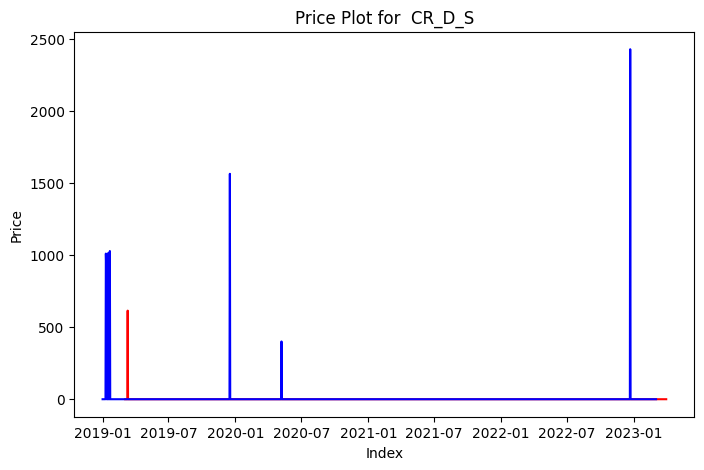

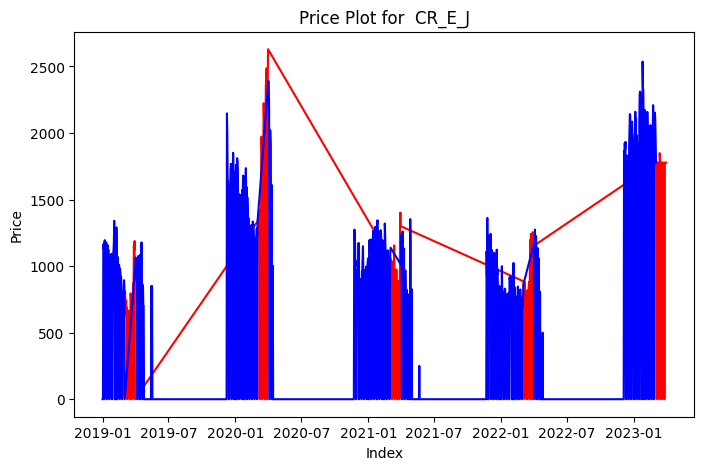

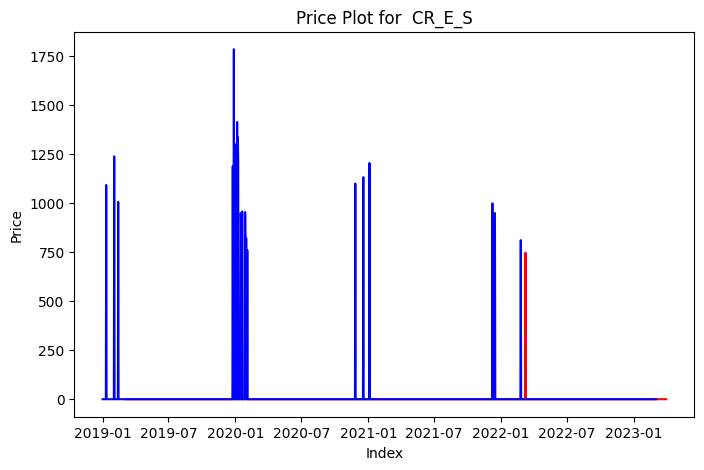

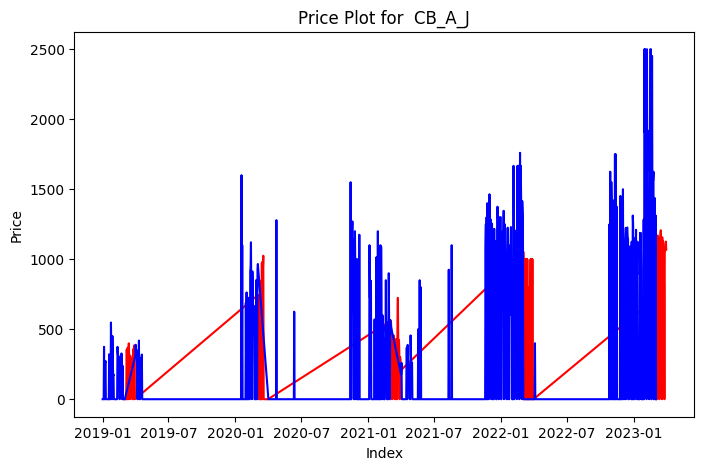

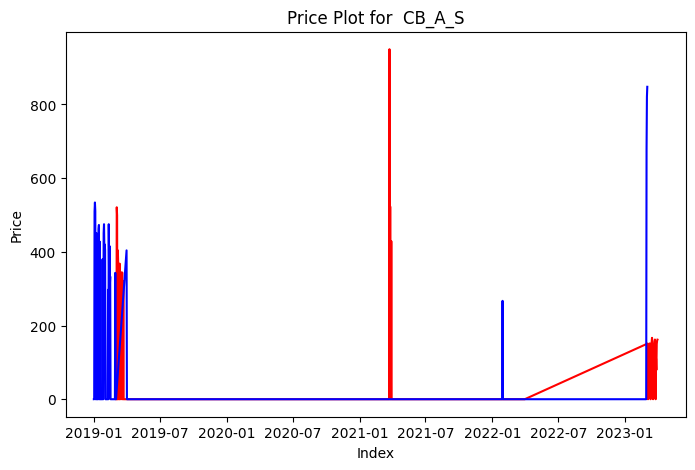

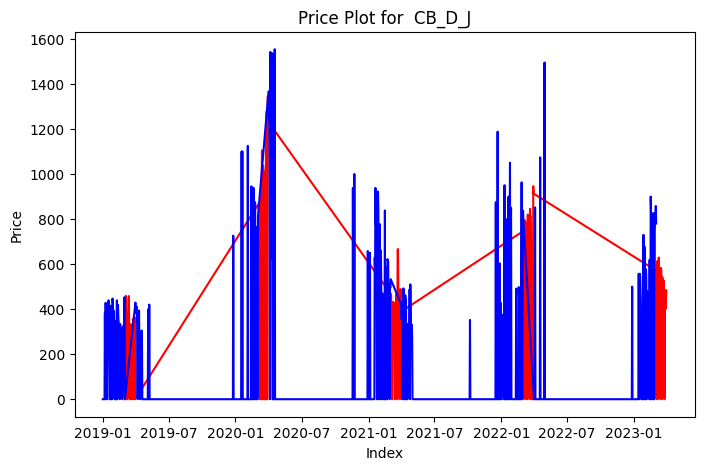

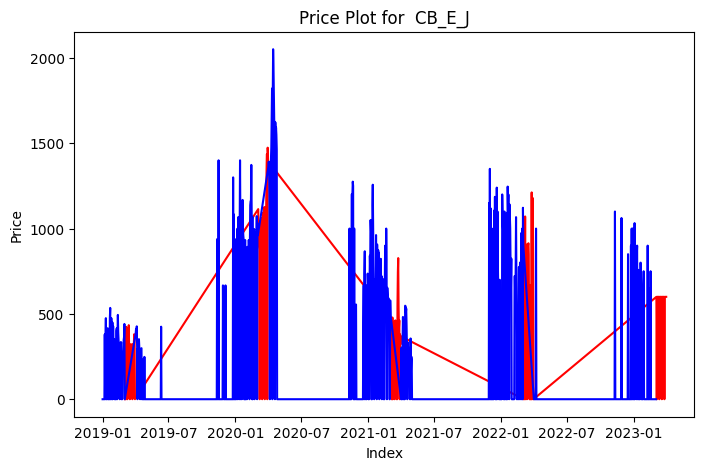

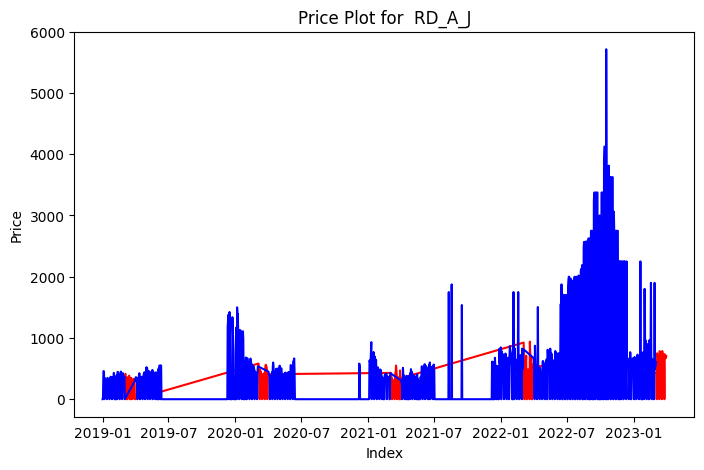

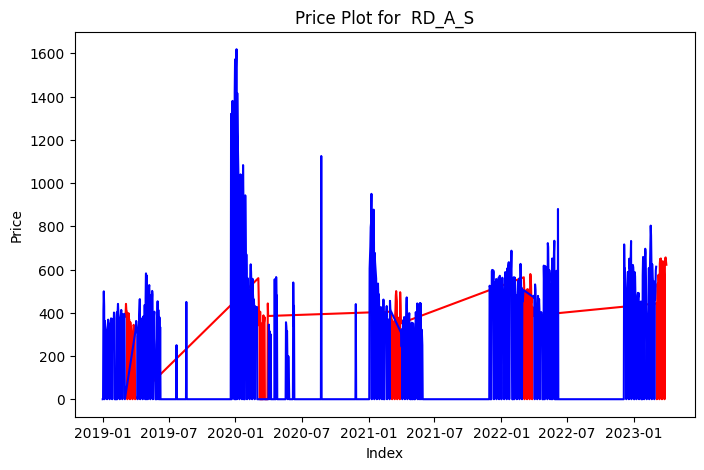

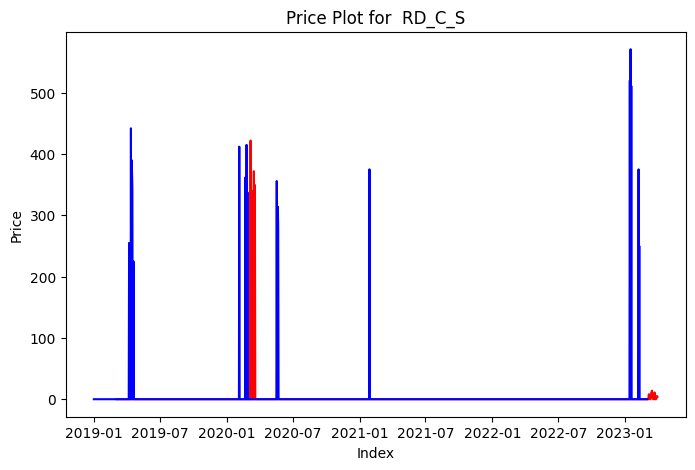

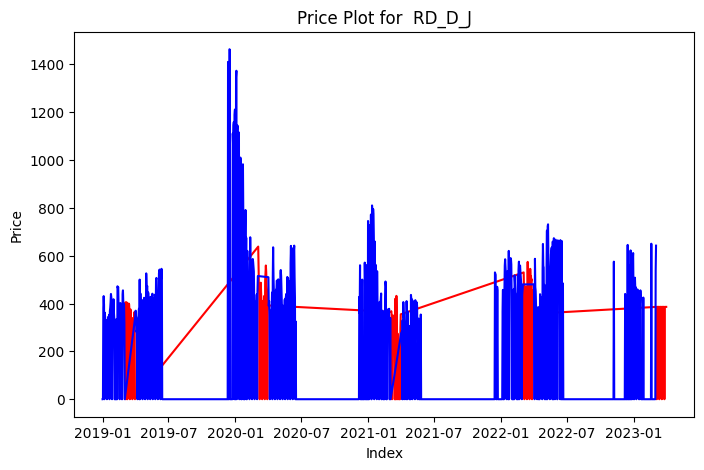

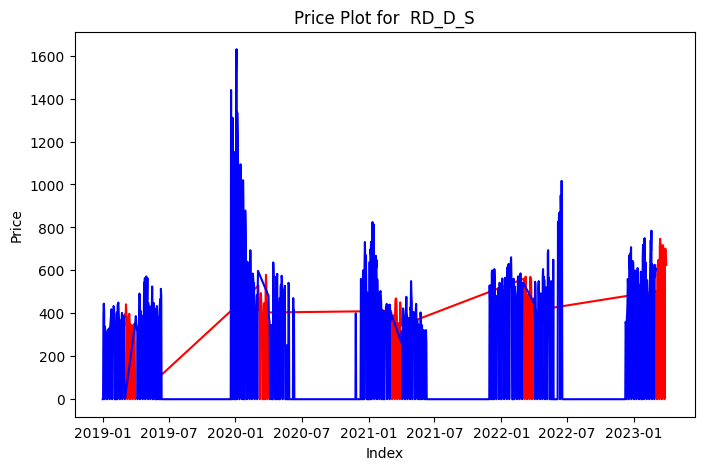

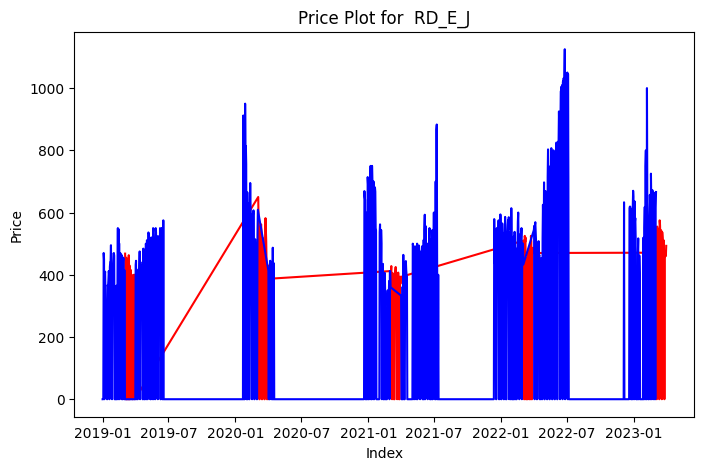

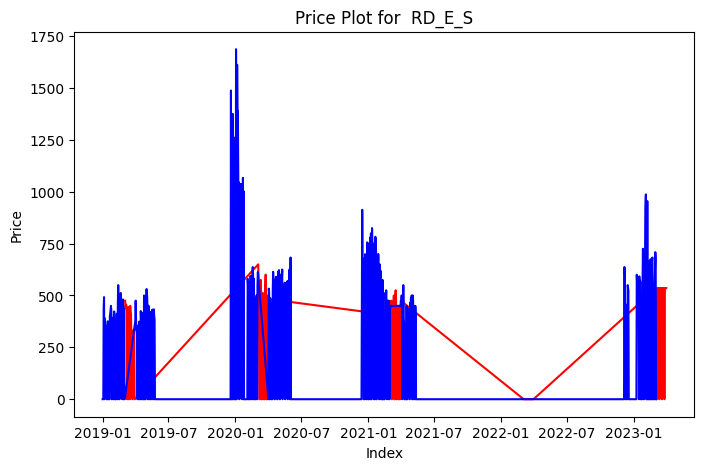

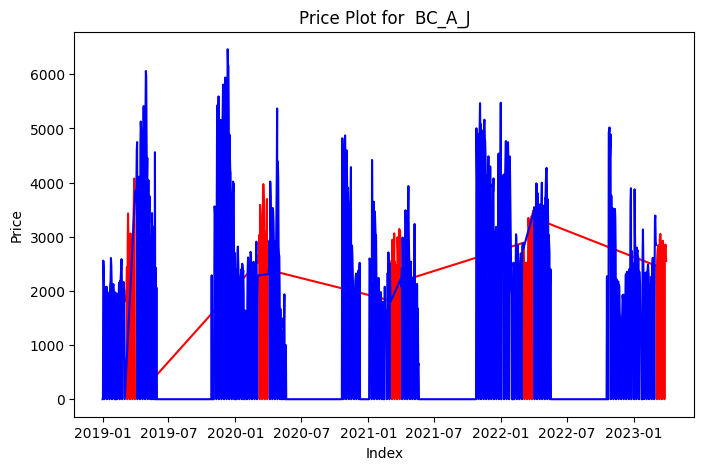

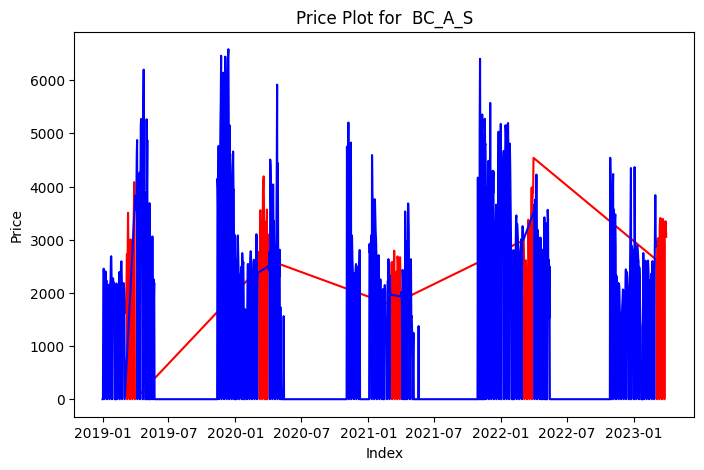

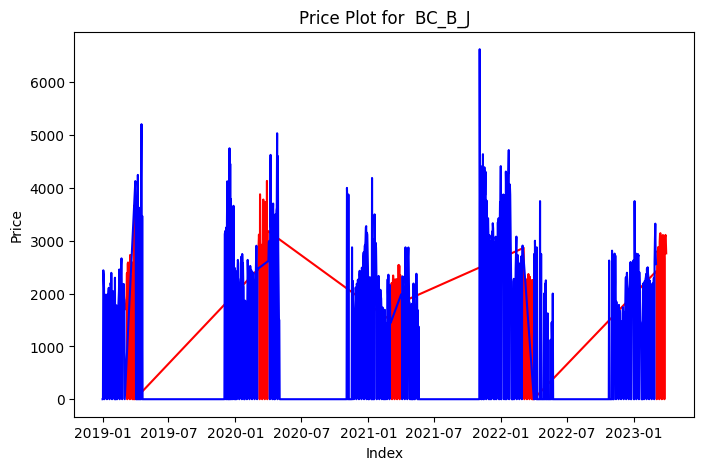

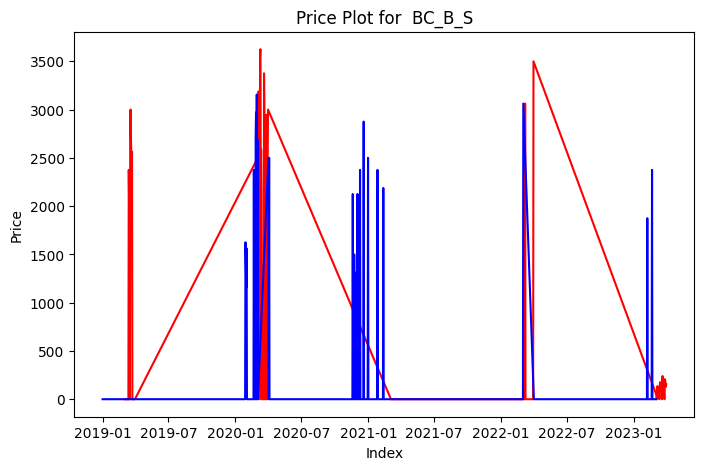

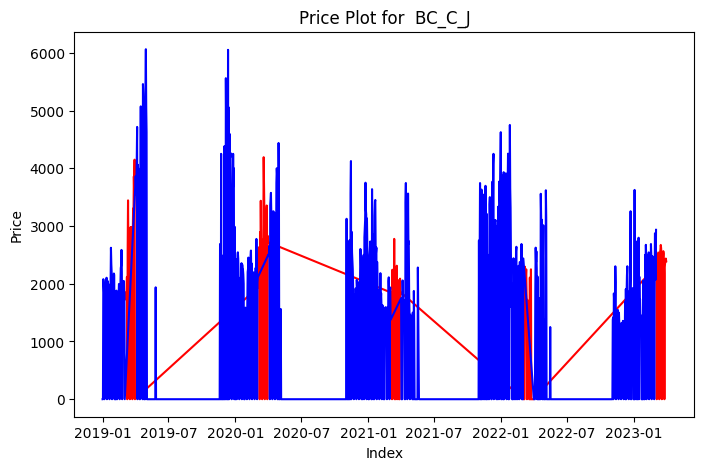

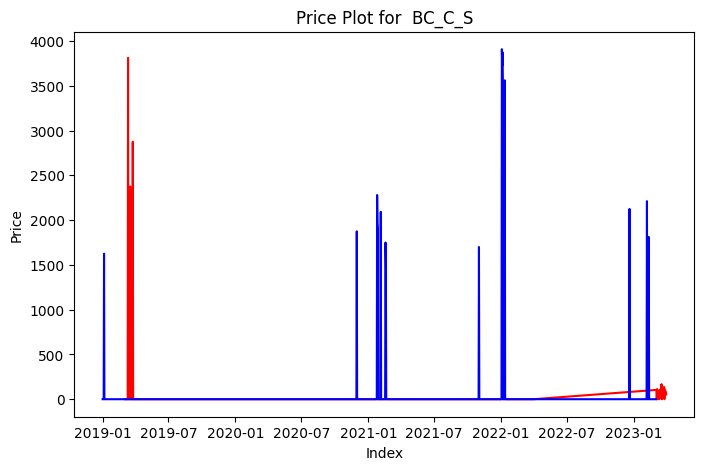

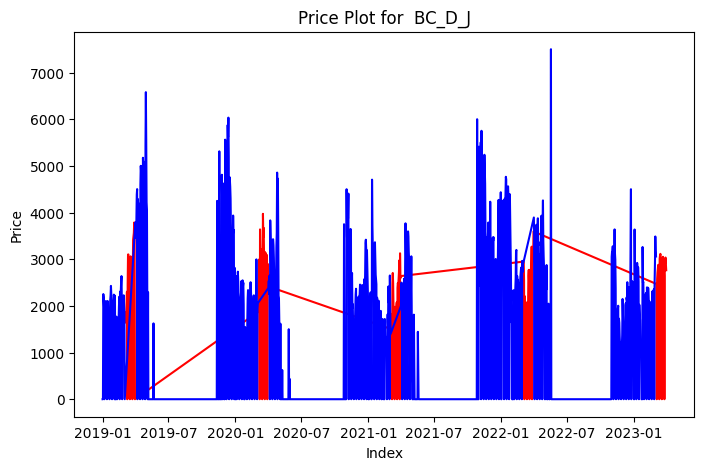

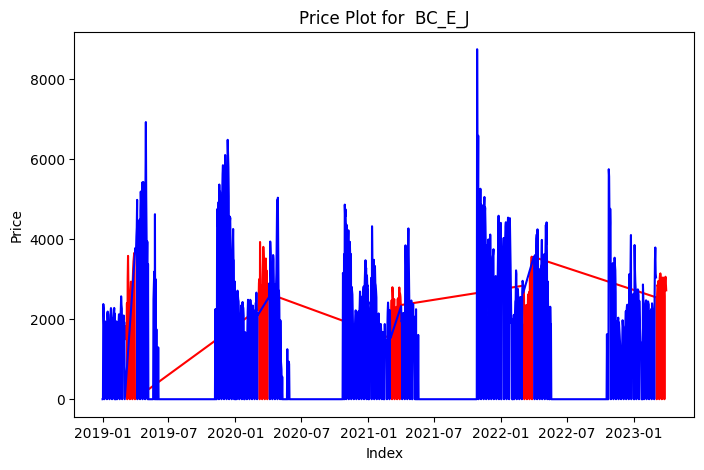

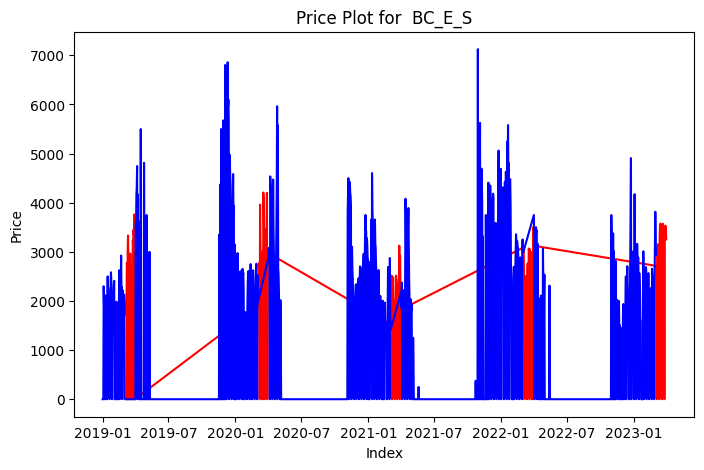

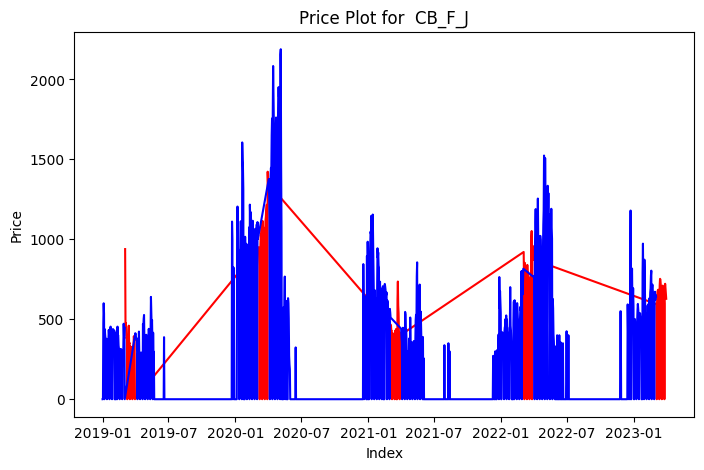

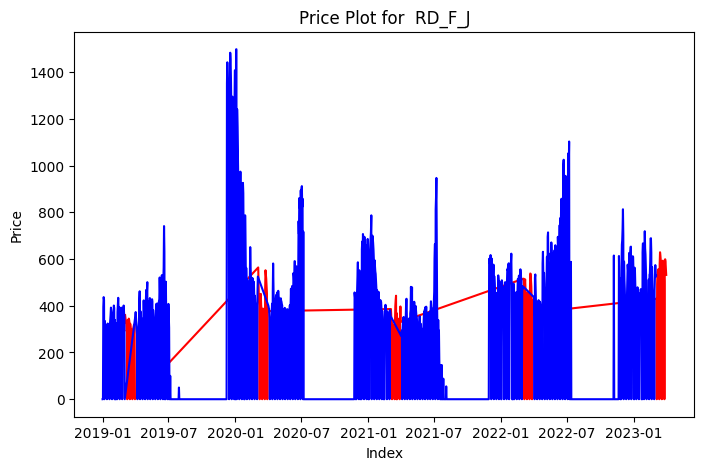

In [34]:
check_nlinear = make_check_data(patchTST)
make_graph_for_each(check_nlinear)

In [119]:
submit = pd.read_csv('./../../DATA/sample_submission.csv').rename(columns={'answer': 'price'} )
submit

,ID,price
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [122]:
# submit[submit['ID'].astype(str).str[:6]== 'CR_B_J']

# for  submit['ID'].astype(str).str[:6]== 'CR_B_J', 'CB_E_J','RD_E_S' 
# submit['price'] will use nlinear['price']
# and for others, submit['price'] = nlinear['price']*0.57 + new_automl['price']*0.45

for id in submit['ID']:
    if str(id).startswith(('CR_B_J', 'CB_E_J', 'RD_E_S')):
        submit.loc[submit['ID'] == id, 'price'] = nlinear.loc[nlinear['ID']==id,'price']
    else:
        submit.loc[submit['ID'] == id, 'price'] = nlinear.loc[nlinear['ID']==id, 'price'] * 0.57 + new_automl.loc[new_automl['ID']==id, 'price'] * 0.45


In [124]:
submit.to_csv('../../DATA/SUBMIT/newautoml_nlinear.csv', index=False)

In [2]:
sub1 = pd.read_csv('../../DATA/SUBMIT/Nlinear2.csv')
sub2 = pd.read_csv('../../DATA/SUBMIT/Dlinear1.csv')

In [3]:
sub2['answer'] = sub2['answer']*0.5 + sub1['answer']*0.5

In [5]:
sub2.to_csv('dlin_nlin2.csv', index=False)